In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


- step: представляет собой единицу времени, где 1 шаг равен 1 часу
- type: тип онлайн-транзакции
- amount: сумма транзакции
- nameOrig: клиент, начинающий транзакцию
- oldbalanceOrg: баланс до транзакции
- newbalanceOrig: баланс после транзакции
- nameDest: получатель транзакции
- oldbalanceDest: начальный баланс получателя до транзакции
- newbalanceDest: новый баланс получателя после транзакции
- isFraud: мошенническая транзакция

In [4]:
df.shape

(6362620, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### EDA

In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

In [9]:
df.isFraud.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [10]:
df.isFraud.value_counts(normalize = True)*100

isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64

In [10]:
step_unique = df.step.unique()
step_unique[:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [11]:
grouped_df = df.groupby('step').agg(
    total_transactions = ('isFraud', 'count'),
    fraudelent_transaction = ('isFraud', 'sum')
)

grouped_df['fraud_percentage'] = (grouped_df['fraudelent_transaction'] / grouped_df['total_transactions']) * 100

grouped_df.head(10)

,total_transactions,fraudelent_transaction,fraud_percentage
step,,,
1,2708,16,0.590842
2,1014,8,0.788955
3,552,4,0.724638
4,565,10,1.769912
5,665,6,0.902256
6,1660,22,1.325301
7,6837,12,0.175516
8,21097,12,0.056880
9,37628,19,0.050494


In [12]:
grouped_df.iloc[50:60]

,total_transactions,fraudelent_transaction,fraud_percentage
step,,,
51,14,14,100.0
52,8,8,100.0
53,10,10,100.0
54,4,4,100.0
55,12,12,100.0
56,18,18,100.0
57,6,6,100.0
58,20,20,100.0
59,20,20,100.0


In [13]:
df.type.value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

- CASH_OUT - это транзакция, при которой клиент снимает деньги со своего счета.  Пример: Снятие наличных через банкомат.
- PAYMENT - Оплата счетов или услуг. Это транзакции, когда деньги списываются со счета клиента и направляются в пользу поставщика услуг. Пример: Оплата коммунальных услуг.
- CASH_IN - Пополнение счета клиента. Это обратная операция к CASH_OUT. Примеры: Зачисление зарплаты.
- TRANSFER - Перевод денег с одного счета на другой. Пример: Клиент переводит деньги другому человеку или компании.
- DEBIT - Прямая дебетовая операция, при которой деньги снимаются с банковского счета клиента. Пример: Списание денег по подписке или регулярный платеж (auto-debit)

In [14]:
type_analysis = df.groupby('type').agg(
    total_transactions = ('isFraud', 'count'),
    fraudulent_transactions = ('isFraud', 'sum')
)
type_analysis['fraud_percentage'] = (type_analysis['fraudulent_transactions'] / type_analysis['total_transactions']) * 100

type_analysis

,total_transactions,fraudulent_transactions,fraud_percentage
type,,,
CASH_IN,1399284,0,0.000000
CASH_OUT,2237500,4116,0.183955
DEBIT,41432,0,0.000000
PAYMENT,2151495,0,0.000000
TRANSFER,532909,4097,0.768799


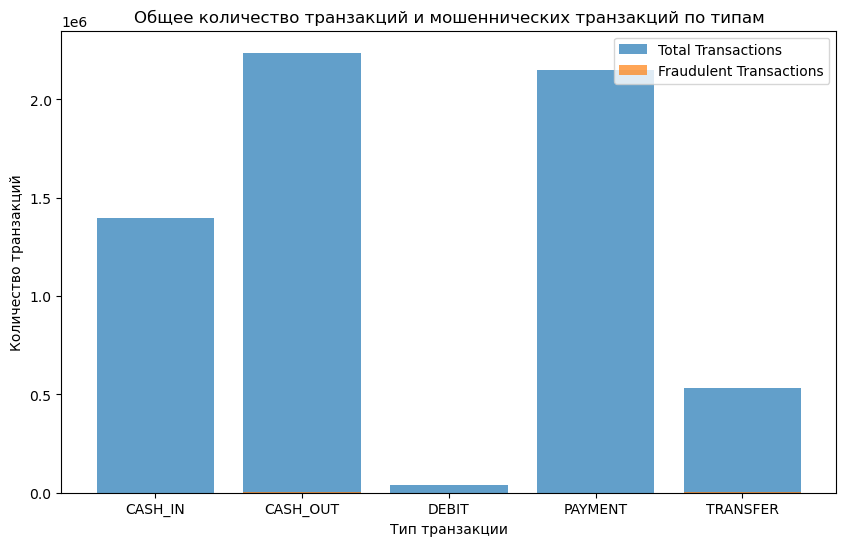

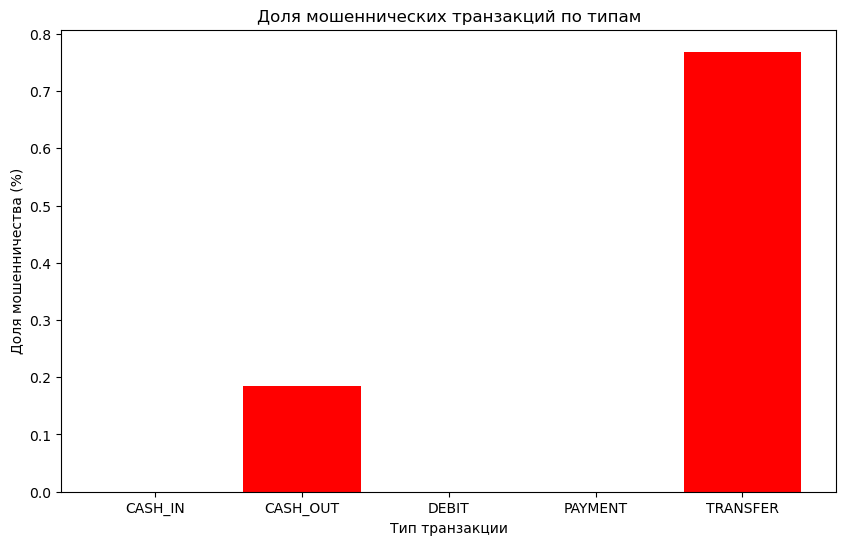

In [15]:
plt.figure(figsize=(10, 6))
plt.bar(type_analysis.index, type_analysis['total_transactions'], label='Total Transactions', alpha=0.7)
plt.bar(type_analysis.index, type_analysis['fraudulent_transactions'], label='Fraudulent Transactions', alpha=0.7)
plt.title('Общее количество транзакций и мошеннических транзакций по типам')
plt.xlabel('Тип транзакции')
plt.ylabel('Количество транзакций')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(type_analysis.index, type_analysis['fraud_percentage'], color='red')
plt.title('Доля мошеннических транзакций по типам')
plt.xlabel('Тип транзакции')
plt.ylabel('Доля мошенничества (%)')
plt.show()

- Количество уникальных значений в nameOrig и nameDest слишком велико (6 миллионы, 2 миллионы) и они приходить в категориальные данные, когда делаем кодированием с помощью LabelEncoder или OneHotEncoder наша данные бывает очень велико, это может усложнить обработку данных и обучение модели без значительного увеличения точности. 

In [16]:
df = df.drop(columns = ['nameOrig', 'nameDest'])

In [17]:
df.isFlaggedFraud.value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [18]:
flagged_fraud_analysis = df.groupby('isFlaggedFraud')['isFraud'].value_counts()
flagged_fraud_analysis

isFlaggedFraud  isFraud
0               0          6354407
                1             8197
1               1               16
Name: count, dtype: int64

Из этого код хорошо виден что столбец isFlaggedFraud дублирует значение isFraud и этого столбец можно удалить

In [19]:
df = df.drop(columns = ['isFlaggedFraud'])

In [20]:
df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1


In [21]:
pd.options.display.float_format = '{:.2f}'.format
df.amount.describe()

count    6362620.00
mean      179861.90
std       603858.23
min            0.00
25%        13389.57
50%        74871.94
75%       208721.48
max     92445516.64
Name: amount, dtype: float64

In [22]:
zero_amount = df[df['amount'] == 0]
print(f"Количество транзакций с нулевой суммой: {len(zero_amount)}")

high_threshold = df['amount'].quantile(0.99)
print(f"99-й процентиль суммы транзакции: {high_threshold}")

high_amount = df[df['amount'] > high_threshold]
print(f"Количество транзакций с суммой выше 99-го процентиля: {len(high_amount)}")

Количество транзакций с нулевой суммой: 16
99-й процентиль суммы транзакции: 1615979.4715999917
Количество транзакций с суммой выше 99-го процентиля: 63627


In [23]:
zero_amount_fraud = df[df['amount'] == 0]['isFraud'].value_counts()
zero_amount_fraud

isFraud
1    16
Name: count, dtype: int64

In [24]:
df = df[df['amount'] != 0]

In [25]:
high_amount_fraud = df[df['amount'] > 1615979.47]['isFraud'].value_counts()
high_amount_fraud

isFraud
0    61658
1     1969
Name: count, dtype: int64

Из этого анализа хорошо видно что многие мошеничество были с большими суммами

In [26]:
high_amount_data = df[df['amount'] > 1615979.47]
high_amount_fraud_percentage = high_amount_data['isFraud'].mean() * 100
print(f"Доля мошенничества среди транзакций с высокой суммой: {high_amount_fraud_percentage:.2f}%")

Доля мошенничества среди транзакций с высокой суммой: 3.09%


Высокие суммы связаны с мошенничеством:
Хотя большинство транзакций с большими суммами (96.91%) не мошеннические, почти 3.09% являются мошенническими, что значительно выше, чем средняя доля мошенничества для всего набора данных.

### One_Hot_Encoder

In [27]:
from sklearn.preprocessing import OneHotEncoder

In [28]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_columns = encoder.fit_transform(df.select_dtypes(include=['object']))

encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out())
data_encoded_one = df.drop(columns=df.select_dtypes(include=['object']).columns)
df = pd.concat([data_encoded_one, encoded_df], axis=1)

df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1.00,9839.64,170136.00,160296.36,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,1.00,1864.28,21249.00,19384.72,0.00,0.00,0.00,0.00,0.00,1.00,0.00
2,1.00,181.00,181.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
3,1.00,181.00,181.00,0.00,21182.00,0.00,1.00,1.00,0.00,0.00,0.00
4,1.00,11668.14,41554.00,29885.86,0.00,0.00,0.00,0.00,0.00,1.00,0.00


### Train test split

In [29]:
from sklearn.model_selection import train_test_split

In [31]:
fraud = df[df['isFraud'] == 1]
non_fraud = df[df['isFraud'] == 0]

fraud_sample = fraud

non_fraud_sample = non_fraud.sample(n=100000 - len(fraud_sample), random_state=42)
sampled_data = pd.concat([fraud_sample, non_fraud_sample], axis=0)

data = sampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [34]:
X = data.drop(columns=['isFraud'])
y = data['isFraud']

data_combined = X.copy()
data_combined['isFraud'] = y

data_combined = data_combined.dropna()

X = data_combined.drop(columns=['isFraud'])
y = data_combined['isFraud']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(69988, 10)
(29996, 10)
(69988,)
(29996,)


#### StandardScaler

In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Classification

### LogisticRegression

In [42]:
LR_model = LogisticRegression(max_iter = 1000, random_state=42)
LR_model.fit(X_train, y_train)

y_pred_lr = LR_model.predict(X_test)
y_pred_lr_proba = LR_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_lr)
roc_auc_lr_proba = roc_auc_score(y_test, y_pred_lr_proba)

print(f"Accuracy: {accuracy}")
print(f"ROC_AUC: {roc_auc_lr_proba}")

Accuracy: 0.9681624216562208
ROC_AUC: 0.9683573165863597


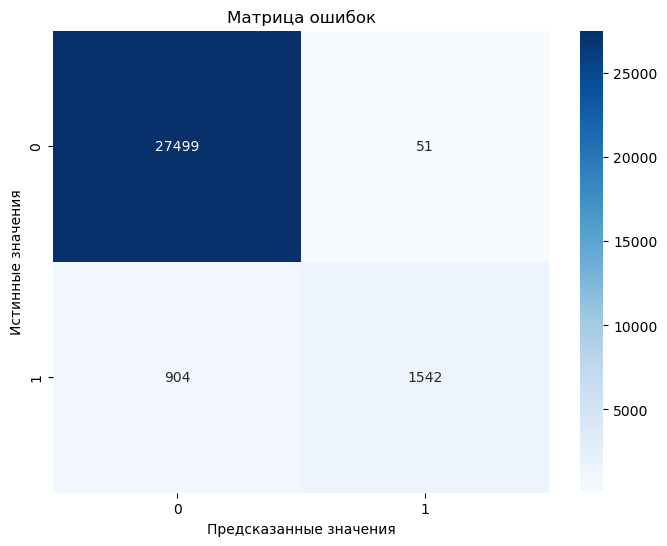

In [43]:
conf_matrix = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)

In [50]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_pred_knn)

print(f"Accuracy: {accuracy}")
print(f"ROC_AUC: {roc_auc_knn}")

Accuracy: 0.974263235098013
ROC_AUC: 0.8760918451993179


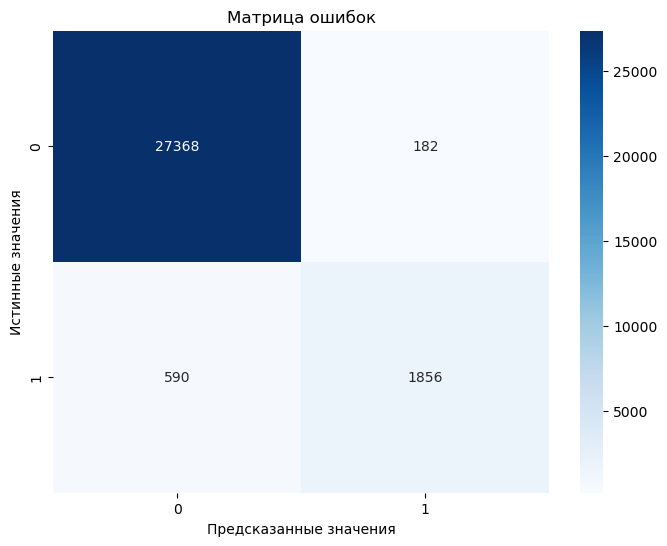

In [51]:
conf_matrix = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)

### Naive Bayes

Accuracy: 0.9073209761301507
ROC_AUC: 0.6567352602048161


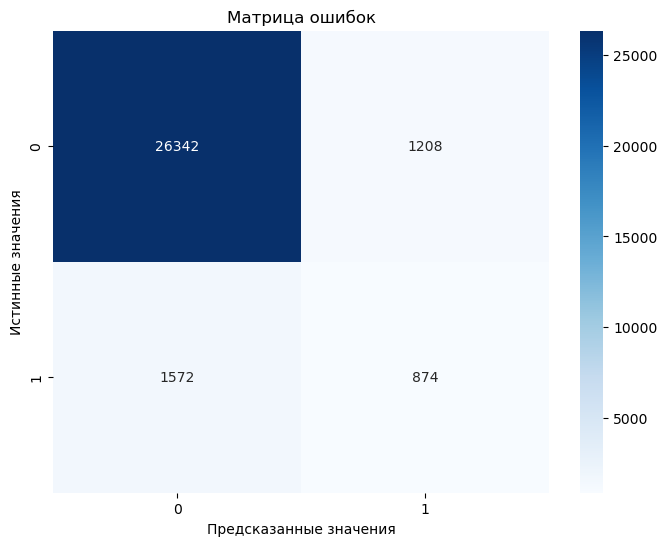

In [53]:
# Build a Gaussian Classifier
model_naive = GaussianNB()

# Model training
model_naive.fit(X_train, y_train)

y_pred_nv = model_naive.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_nv)
roc_auc_nv = roc_auc_score(y_test, y_pred_nv)

print(f'Accuracy: {accuracy}')
print(f"ROC_AUC: {roc_auc_nv}")

conf_matrix = confusion_matrix(y_test, y_pred_nv)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

precision = precision_score(y_test, y_pred_nv)
recall = recall_score(y_test, y_pred_nv)
f1 = f1_score(y_test, y_pred_nv)

### Support Vector Machine

Accuracy: 0.9719629283904521


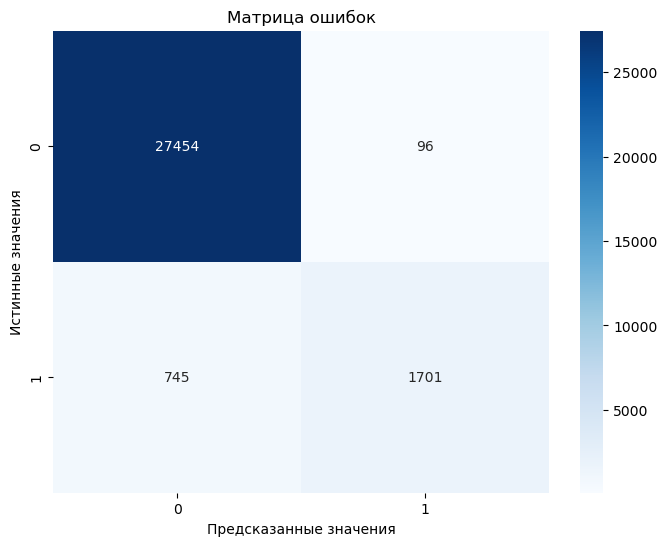

In [46]:
SVM_model = svm.SVC(kernel = 'linear', C=5)
SVM_model.fit(X_train, y_train)

y_pred_spv = SVM_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_spv)

print(f"Accuracy: {accuracy}")

conf_matrix = confusion_matrix(y_test, y_pred_spv)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

precision = precision_score(y_test, y_pred_spv)
recall = recall_score(y_test, y_pred_spv)
f1 = f1_score(y_test, y_pred_spv)

### DecisionTreeClassifier

Accuracy: 0.9806640885451393
ROC_AUC: 0.9844661308584852


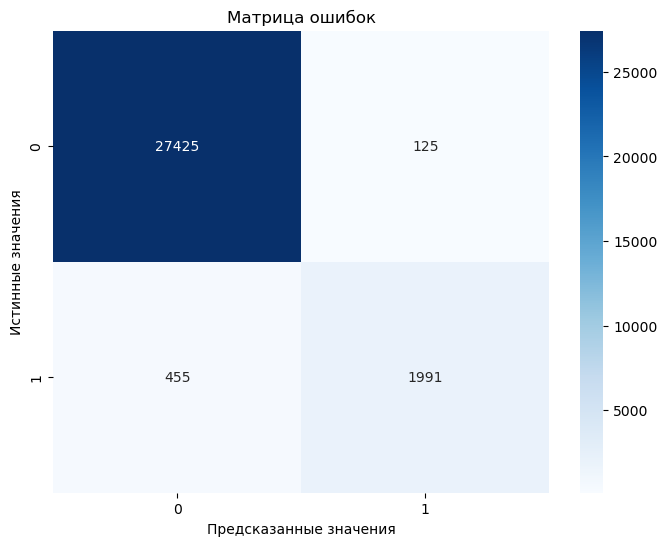

In [54]:
tree_model = DecisionTreeClassifier(max_depth=6)
tree_model.fit(X_train, y_train)

y_pred_tree = tree_model.predict(X_test)
y_pred_tree_proba = tree_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_tree)
roc_auc_tree_proba = roc_auc_score(y_test, y_pred_tree_proba)

print(f"Accuracy: {accuracy}")
print(f"ROC_AUC: {roc_auc_tree_proba}")

conf_matrix = confusion_matrix(y_test, y_pred_tree)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

precision = precision_score(y_test, y_pred_tree)
recall = recall_score(y_test, y_pred_tree)
f1 = f1_score(y_test, y_pred_tree)

### Random Forest

In [57]:
RF_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=RF_model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=0)
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

best_model_rf = grid_search.best_estimator_

Лучшие параметры: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}


Accuracy: 0.992
ROC_AUC: 0.9987550102170587


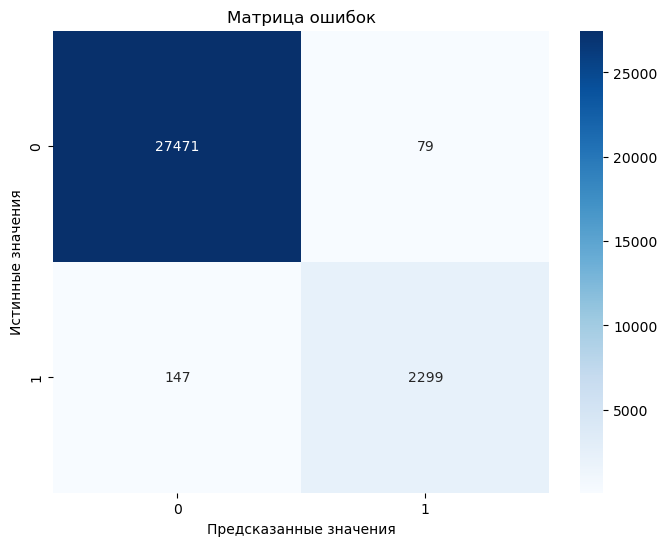

In [58]:
y_pred_forest = best_model_rf.predict(X_test)
y_pred_forest_proba = best_model_rf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_tree)
roc_auc_forest_proba = roc_auc_score(y_test, y_pred_forest_proba)

print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_forest))
print(f"ROC_AUC: {roc_auc_forest_proba}")

conf_matrix = confusion_matrix(y_test, y_pred_forest)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

precision = precision_score(y_test, y_pred_forest)
recall = recall_score(y_test, y_pred_forest)
f1 = f1_score(y_test, y_pred_forest)

### CatBoost Classifier

In [62]:
catboost_model = CatBoostClassifier(random_state=42)

param_grid = {
    'iterations': [500, 1000],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'l2_leaf_reg': [1, 3, 5],
}


grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

best_model_cat = grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0:	learn: 0.4660430	total: 164ms	remaining: 2m 43s
1:	learn: 0.3251601	total: 198ms	remaining: 1m 38s
2:	learn: 0.2338363	total: 221ms	remaining: 1m 13s
3:	learn: 0.1770332	total: 243ms	remaining: 1m
4:	learn: 0.1380408	total: 268ms	remaining: 53.3s
5:	learn: 0.1122767	total: 290ms	remaining: 48s
6:	learn: 0.0954661	total: 311ms	remaining: 44.1s
7:	learn: 0.0826229	total: 336ms	remaining: 41.6s
8:	learn: 0.0751127	total: 358ms	remaining: 39.5s
9:	learn: 0.0683884	total: 384ms	remaining: 38s
10:	learn: 0.0627902	total: 408ms	remaining: 36.7s
11:	learn: 0.0593144	total: 429ms	remaining: 35.4s
12:	learn: 0.0561257	total: 454ms	remaining: 34.5s
13:	learn: 0.0526095	total: 476ms	remaining: 33.5s
14:	learn: 0.0509295	total: 498ms	remaining: 32.7s
15:	learn: 0.0488360	total: 522ms	remaining: 32.1s
16:	learn: 0.0474126	total: 545ms	remaining: 31.5s
17:	learn: 0.0462968	total: 568ms	remaining: 31s
18:	learn: 0.0442169	total: 591ms	re

167:	learn: 0.0131471	total: 4.1s	remaining: 20.3s
168:	learn: 0.0130977	total: 4.12s	remaining: 20.3s
169:	learn: 0.0129916	total: 4.14s	remaining: 20.2s
170:	learn: 0.0129657	total: 4.17s	remaining: 20.2s
171:	learn: 0.0129391	total: 4.19s	remaining: 20.2s
172:	learn: 0.0128955	total: 4.21s	remaining: 20.1s
173:	learn: 0.0128741	total: 4.24s	remaining: 20.1s
174:	learn: 0.0128176	total: 4.26s	remaining: 20.1s
175:	learn: 0.0127954	total: 4.28s	remaining: 20.1s
176:	learn: 0.0127459	total: 4.31s	remaining: 20s
177:	learn: 0.0126979	total: 4.33s	remaining: 20s
178:	learn: 0.0126383	total: 4.36s	remaining: 20s
179:	learn: 0.0125517	total: 4.38s	remaining: 19.9s
180:	learn: 0.0124601	total: 4.4s	remaining: 19.9s
181:	learn: 0.0124138	total: 4.42s	remaining: 19.9s
182:	learn: 0.0123881	total: 4.45s	remaining: 19.9s
183:	learn: 0.0123083	total: 4.47s	remaining: 19.8s
184:	learn: 0.0122768	total: 4.49s	remaining: 19.8s
185:	learn: 0.0122540	total: 4.51s	remaining: 19.8s
186:	learn: 0.012210

333:	learn: 0.0080286	total: 8.05s	remaining: 16.1s
334:	learn: 0.0080086	total: 8.08s	remaining: 16s
335:	learn: 0.0079768	total: 8.1s	remaining: 16s
336:	learn: 0.0079543	total: 8.12s	remaining: 16s
337:	learn: 0.0079433	total: 8.14s	remaining: 16s
338:	learn: 0.0079267	total: 8.17s	remaining: 15.9s
339:	learn: 0.0079199	total: 8.19s	remaining: 15.9s
340:	learn: 0.0078905	total: 8.21s	remaining: 15.9s
341:	learn: 0.0078754	total: 8.24s	remaining: 15.9s
342:	learn: 0.0078588	total: 8.26s	remaining: 15.8s
343:	learn: 0.0078202	total: 8.29s	remaining: 15.8s
344:	learn: 0.0077861	total: 8.31s	remaining: 15.8s
345:	learn: 0.0077600	total: 8.33s	remaining: 15.8s
346:	learn: 0.0077515	total: 8.36s	remaining: 15.7s
347:	learn: 0.0077259	total: 8.38s	remaining: 15.7s
348:	learn: 0.0077145	total: 8.4s	remaining: 15.7s
349:	learn: 0.0077027	total: 8.42s	remaining: 15.6s
350:	learn: 0.0076661	total: 8.45s	remaining: 15.6s
351:	learn: 0.0076470	total: 8.47s	remaining: 15.6s
352:	learn: 0.0076242	

496:	learn: 0.0055212	total: 12.4s	remaining: 12.6s
497:	learn: 0.0054880	total: 12.5s	remaining: 12.6s
498:	learn: 0.0054729	total: 12.5s	remaining: 12.6s
499:	learn: 0.0054567	total: 12.6s	remaining: 12.6s
500:	learn: 0.0054513	total: 12.6s	remaining: 12.5s
501:	learn: 0.0054407	total: 12.6s	remaining: 12.5s
502:	learn: 0.0054370	total: 12.7s	remaining: 12.5s
503:	learn: 0.0054262	total: 12.7s	remaining: 12.5s
504:	learn: 0.0054049	total: 12.7s	remaining: 12.5s
505:	learn: 0.0054013	total: 12.7s	remaining: 12.4s
506:	learn: 0.0053941	total: 12.8s	remaining: 12.4s
507:	learn: 0.0053866	total: 12.8s	remaining: 12.4s
508:	learn: 0.0053779	total: 12.8s	remaining: 12.4s
509:	learn: 0.0053688	total: 12.9s	remaining: 12.4s
510:	learn: 0.0053528	total: 12.9s	remaining: 12.4s
511:	learn: 0.0053439	total: 12.9s	remaining: 12.3s
512:	learn: 0.0053281	total: 13s	remaining: 12.3s
513:	learn: 0.0053136	total: 13s	remaining: 12.3s
514:	learn: 0.0053011	total: 13s	remaining: 12.3s
515:	learn: 0.0052

656:	learn: 0.0040075	total: 16.9s	remaining: 8.82s
657:	learn: 0.0040012	total: 16.9s	remaining: 8.79s
658:	learn: 0.0039951	total: 16.9s	remaining: 8.77s
659:	learn: 0.0039893	total: 17s	remaining: 8.74s
660:	learn: 0.0039817	total: 17s	remaining: 8.71s
661:	learn: 0.0039729	total: 17s	remaining: 8.69s
662:	learn: 0.0039674	total: 17s	remaining: 8.66s
663:	learn: 0.0039642	total: 17.1s	remaining: 8.63s
664:	learn: 0.0039594	total: 17.1s	remaining: 8.6s
665:	learn: 0.0039516	total: 17.1s	remaining: 8.58s
666:	learn: 0.0039438	total: 17.1s	remaining: 8.55s
667:	learn: 0.0039405	total: 17.2s	remaining: 8.53s
668:	learn: 0.0039252	total: 17.2s	remaining: 8.5s
669:	learn: 0.0039228	total: 17.2s	remaining: 8.47s
670:	learn: 0.0039198	total: 17.2s	remaining: 8.45s
671:	learn: 0.0039112	total: 17.3s	remaining: 8.42s
672:	learn: 0.0039059	total: 17.3s	remaining: 8.39s
673:	learn: 0.0039001	total: 17.3s	remaining: 8.37s
674:	learn: 0.0038951	total: 17.3s	remaining: 8.34s
675:	learn: 0.0038848	

821:	learn: 0.0030295	total: 20.8s	remaining: 4.5s
822:	learn: 0.0030260	total: 20.8s	remaining: 4.47s
823:	learn: 0.0030200	total: 20.8s	remaining: 4.45s
824:	learn: 0.0030154	total: 20.9s	remaining: 4.42s
825:	learn: 0.0030114	total: 20.9s	remaining: 4.4s
826:	learn: 0.0030045	total: 20.9s	remaining: 4.37s
827:	learn: 0.0029995	total: 20.9s	remaining: 4.35s
828:	learn: 0.0029979	total: 21s	remaining: 4.32s
829:	learn: 0.0029897	total: 21s	remaining: 4.3s
830:	learn: 0.0029880	total: 21s	remaining: 4.27s
831:	learn: 0.0029857	total: 21s	remaining: 4.25s
832:	learn: 0.0029752	total: 21.1s	remaining: 4.22s
833:	learn: 0.0029682	total: 21.1s	remaining: 4.2s
834:	learn: 0.0029622	total: 21.1s	remaining: 4.17s
835:	learn: 0.0029600	total: 21.1s	remaining: 4.14s
836:	learn: 0.0029574	total: 21.1s	remaining: 4.12s
837:	learn: 0.0029531	total: 21.2s	remaining: 4.09s
838:	learn: 0.0029468	total: 21.2s	remaining: 4.07s
839:	learn: 0.0029440	total: 21.2s	remaining: 4.04s
840:	learn: 0.0029440	to

987:	learn: 0.0022972	total: 24.7s	remaining: 300ms
988:	learn: 0.0022952	total: 24.7s	remaining: 275ms
989:	learn: 0.0022918	total: 24.7s	remaining: 250ms
990:	learn: 0.0022851	total: 24.8s	remaining: 225ms
991:	learn: 0.0022823	total: 24.8s	remaining: 200ms
992:	learn: 0.0022807	total: 24.8s	remaining: 175ms
993:	learn: 0.0022771	total: 24.8s	remaining: 150ms
994:	learn: 0.0022757	total: 24.9s	remaining: 125ms
995:	learn: 0.0022757	total: 24.9s	remaining: 99.9ms
996:	learn: 0.0022691	total: 24.9s	remaining: 74.9ms
997:	learn: 0.0022691	total: 24.9s	remaining: 49.9ms
998:	learn: 0.0022681	total: 24.9s	remaining: 25ms
999:	learn: 0.0022655	total: 25s	remaining: 0us
Лучшие параметры: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


Accuracy: 0.997
ROC_AUC: 0.9992706637600853


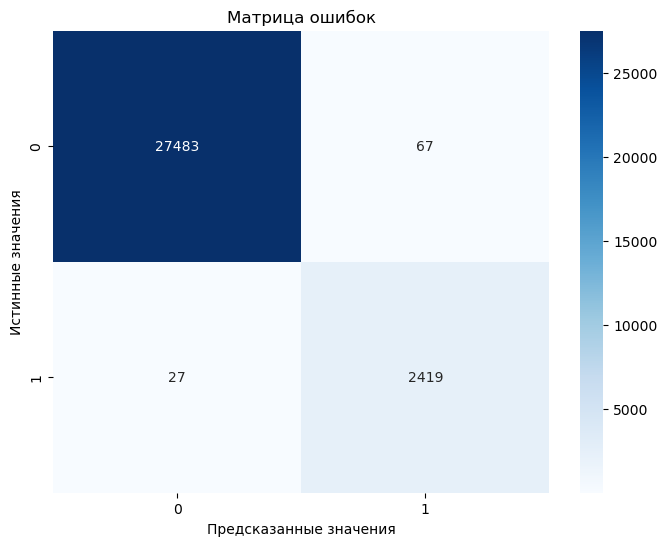

In [63]:
y_pred_catboost = best_model_cat.predict(X_test)
y_pred_cat_proba = best_model_cat.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_catboost)
roc_auc_cat_proba = roc_auc_score(y_test, y_pred_cat_proba)

print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_catboost))
print(f"ROC_AUC: {roc_auc_cat_proba}")

conf_matrix = confusion_matrix(y_test, y_pred_catboost)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

precision = precision_score(y_test, y_pred_catboost)
recall = recall_score(y_test, y_pred_catboost)
f1 = f1_score(y_test, y_pred_catboost)

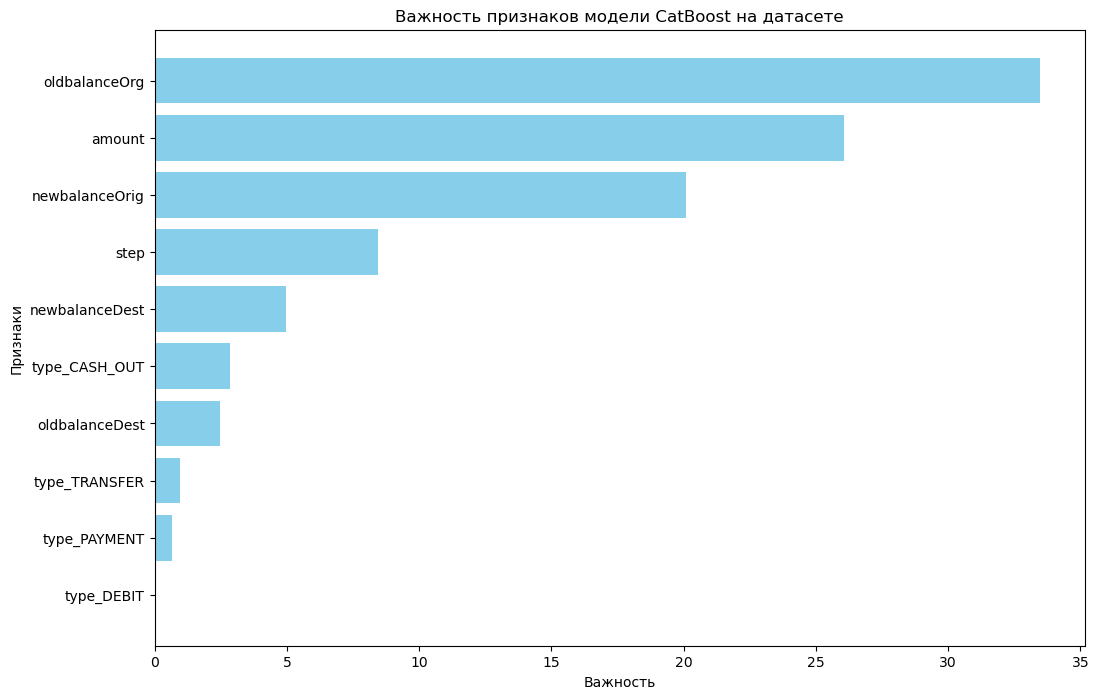

In [66]:
from catboost import CatBoostClassifier, Pool

importances = best_model_cat.get_feature_importance(Pool(X_train, label=y_train))
features = X.columns

# Создание DataFrame для сортировки
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Важность признаков модели CatBoost на датасете')
plt.show()

### XGBoost

In [64]:
xgboost_model = XGBClassifier(random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],       # Скорость обучения
    'n_estimators': [100, 200, 300],         # Количество деревьев
    'max_depth': [3, 6, 9],                 # Глубина деревьев
    'reg_alpha': [0, 0.1, 1],               # L1-регуляризация
    'reg_lambda': [1, 1.5, 2]               # L2-регуляризация
}

grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=0)
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_

Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1}


Accuracy: 0.996
ROC_AUC: 0.9989555747151169


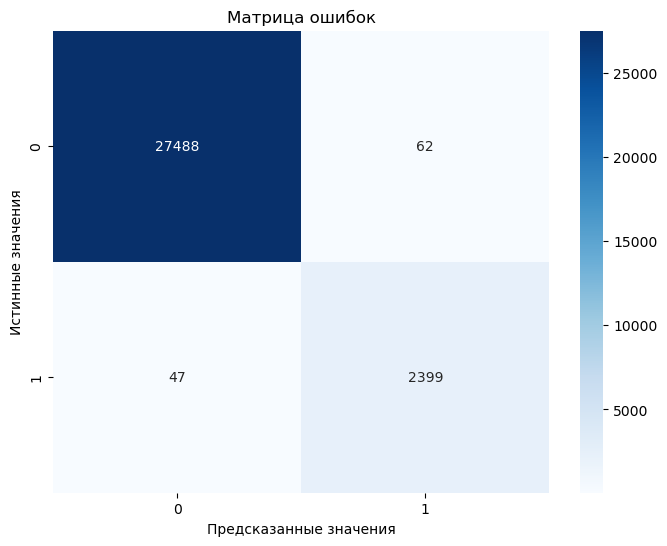

In [65]:
y_pred_xgboost = best_model.predict(X_test)
y_pred_xgboost_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_xgboost)
roc_auc_xgboost_proba = roc_auc_score(y_test, y_pred_xgboost_proba)

print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_xgboost))
print(f"ROC_AUC: {roc_auc_xgboost_proba}")

conf_matrix = confusion_matrix(y_test, y_pred_xgboost)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

precision = precision_score(y_test, y_pred_xgboost)
recall = recall_score(y_test, y_pred_xgboost)
f1 = f1_score(y_test, y_pred_xgboost)

### LightGBM

Accuracy: 0.995
ROC_AUC: 0.9972919081191857


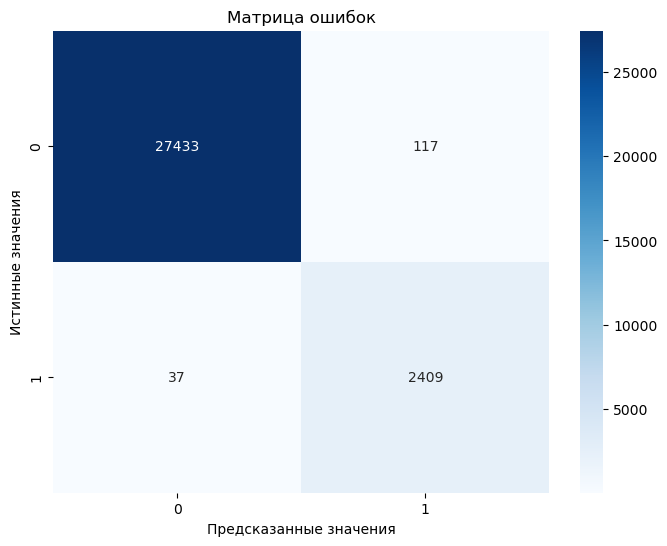

In [69]:
lgbm_model = LGBMClassifier(verbose=-200)
lgbm_model.fit(X_train, y_train)

y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_lgbm_proba = lgbm_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_lgbm)
roc_auc_lgbm_proba = roc_auc_score(y_test, y_pred_lgbm_proba)

print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_lgbm))
print(f"ROC_AUC: {roc_auc_lgbm_proba}")

conf_matrix = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

precision = precision_score(y_test, y_pred_lgbm)
recall = recall_score(y_test, y_pred_lgbm)
f1 = f1_score(y_test, y_pred_lgbm)

In [70]:
import joblib

joblib.dump(best_model, 'xgboost_model.pkl')

['xgboost_model.pkl']

In [71]:
data.to_csv('processed_data.csv', index=False)

# Regression 

In [32]:
data = df[:40000]
data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1.00,9839.64,170136.00,160296.36,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,1.00,1864.28,21249.00,19384.72,0.00,0.00,0.00,0.00,0.00,1.00,0.00
2,1.00,181.00,181.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
3,1.00,181.00,181.00,0.00,21182.00,0.00,1.00,1.00,0.00,0.00,0.00
4,1.00,11668.14,41554.00,29885.86,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [33]:
X = data.drop(columns = ['amount'])
y = data['amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28000, 10)
(12000, 10)
(28000,)
(12000,)


In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [62]:
models = {
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(random_state = 42),
        'params': {
            'max_depth': [5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },

    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state = 42),
        'params': {
            'n_estimators' : [50, 100, 200],
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },

    'SVR' : {
        'model' : SVR(),
        'params' : {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    },
 
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [1, 3, 5],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
        }
    },

    'XGBoost': {
        'model': xgb.XGBRegressor(random_state = 42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    }
}


In [58]:
best_models = {}
for model_name, model_info in models.items():
    grid_search = GridSearchCV(estimator = model_info["model"], param_grid = model_info['params'], cv = 3, n_jobs = -1, verbose = 1, scoring= 'neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_


predictions = {}
for model_name, model in best_models.items():
    predictions[model_name] = model.predict(X_test)


metrics = {}
for model_name, y_pred in predictions.items():
    mse = mean_squared_error(y_train, best_models[model_name].predict(X_train))
    mae = mean_absolute_error(y_train, best_models[model_name].predict(X_train))
    r2 = r2_score(y_train, best_models[model_name].predict(X_train))
    rmse = np.sqrt(mse)
    
    metrics[model_name] = {
        "MSE": mse,
        "MAE": mae,
        "R2": r2,
        "RMSE": rmse
    }

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [59]:
# Вывести результаты 
for model_name, metric in metrics.items():
    print(f'{model_name}:')
    print(f"  MSE: {metric['MSE']}")
    print(f"  MAE: {metric['MAE']}")
    print(f"  R2: {metric['R2']}")
    print(f"  RMSE: {metric['RMSE']}")
    print()

# Найдение лучшую модель на основе оценки R2
best_model_name = max(metrics, key = lambda x: metrics[x]['R2'])
best_model = best_models[best_model_name]

# Сгенерировать прогнозы для тестового набора, используя лучшую модель
ensemble = best_model.predict(X_test)

DecisionTreeRegressor:
  MSE: 32819011014.930725
  MAE: 79706.54305225523
  R2: 0.6768155007276454
  RMSE: 181160.1805445411

RandomForestRegressor:
  MSE: 17179780506.138563
  MAE: 59163.76073369414
  R2: 0.8308224840181988
  RMSE: 131071.66172036793

SVR:
  MSE: 79858870466.12886
  MAE: 98778.44079361053
  R2: 0.2135915048655782
  RMSE: 282593.1182214614

KNeighborsRegressor:
  MSE: 13727317.516781272
  MAE: 833.0918455
  R2: 0.9998648205384375
  RMSE: 3705.0394757385884

XGBoost:
  MSE: 21646137541.571045
  MAE: 63976.797309549125
  R2: 0.7868401299670327
  RMSE: 147126.26394213593



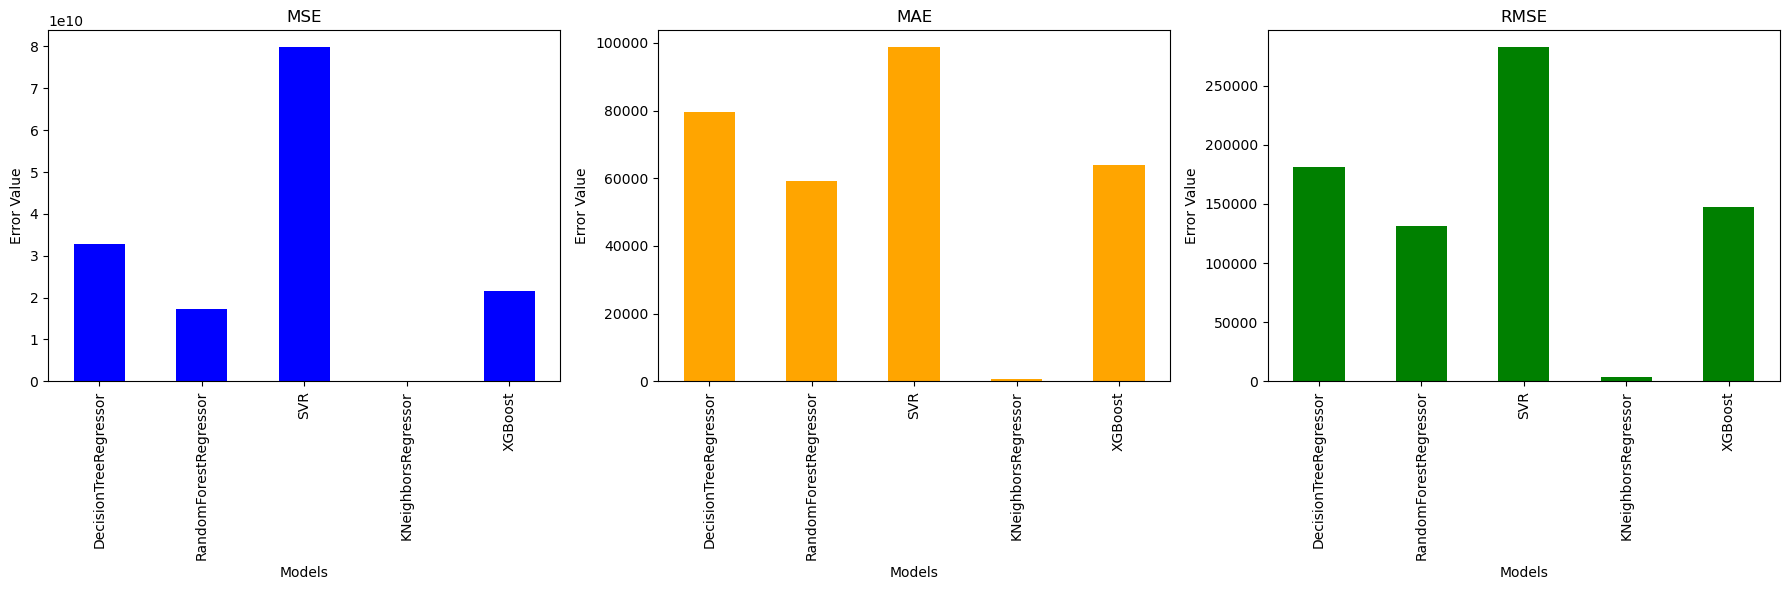

In [60]:
metrics_df = pd.DataFrame(metrics).T

fig, ax = plt.subplots(1, 3, figsize = (18, 6))

metrics_df['MSE'].plot(kind = 'bar', ax = ax[0], color = 'blue', title = 'MSE', legend = False)
ax[0].set_ylabel('Error Value')
ax[0].set_xlabel('Models')

metrics_df['MAE'].plot(kind = 'bar', ax = ax[1], color = 'orange', title='MAE', legend = False)
ax[1].set_ylabel('Error Value')
ax[1].set_xlabel('Models')

metrics_df['RMSE'].plot(kind = 'bar', ax = ax[2], color = 'green', title = 'RMSE', legend = False)
ax[2].set_ylabel('Error Value')
ax[2].set_xlabel('Models')

plt.tight_layout()
plt.show()

In [61]:
metrics_df

,MSE,MAE,R2,RMSE
DecisionTreeRegressor,32819011014.93,79706.54,0.68,181160.18
RandomForestRegressor,17179780506.14,59163.76,0.83,131071.66
SVR,79858870466.13,98778.44,0.21,282593.12
KNeighborsRegressor,13727317.52,833.09,1.00,3705.04
XGBoost,21646137541.57,63976.80,0.79,147126.26
